In [10]:
from functions import *
import pandas as pd
import seaborn as sns
import statistics
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, median_absolute_error, mean_squared_error
%matplotlib inline
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import numpy as np
from numpy import mean
from scipy.stats import pearsonr, ttest_ind, spearmanr

SAMPLE = 5000 # Training sample (Used: 5000, 20000)
GRANULARITY = 15000 # Only work with the last X rows of data sets (Used: 15000, 220000)
REMOVE_OUTLIERS = False # False, or Number for whisker, 3 = only remove extreme outliers
ONLY_TRANSPARENT = False # False, or True, filter for only TSP blocks

SAVE_FIGURES = False
DPI = 300
FILE = '.pdf'

blocks_HDD = pd.read_csv("./raw_data/HDD/eval_all_blocks.csv", names=["BLOCK", "BLOCK_NS"])
blocks_SSD = pd.read_csv("./raw_data/SSD/eval_all_blocks.csv", names=["BLOCK", "BLOCK_NS"])

blocks_info = pd.read_csv("./data/enhanced_block.csv", names=["BLOCK", "SIZE", "VERSION", "numberTX", "numberVin", "numberVout", "numberJoinSplit", "numbervShieldedSpend", "numbervShieldedOutput"])

# Remove extreme outliers
if REMOVE_OUTLIERS:
    old_count_hdd = blocks_HDD['BLOCK'].count()
    old_count_ssd = blocks_SSD['BLOCK'].count()
    blocks_HDD = subset_by_iqr(blocks_HDD, 'BLOCK_NS', whisker_width=REMOVE_OUTLIERS) 
    blocks_SSD = subset_by_iqr(blocks_SSD, 'BLOCK_NS', whisker_width=REMOVE_OUTLIERS)
    print('Outliers: {} removed for HDD and {} removed for SSD'.format(old_count_hdd - blocks_HDD['BLOCK'].count(), old_count_ssd - blocks_SSD['BLOCK'].count()))

# Merge Data
blocks = blocks_SSD.merge(blocks_HDD, how='inner', left_on="BLOCK", right_on="BLOCK", suffixes=('_SSD', '_HDD'))
blocks = blocks.merge(blocks_info, how='inner', left_on="BLOCK", right_on="BLOCK")
onlyContainingTransparent = blocks.loc[(blocks['numberJoinSplit'] == 0) & (blocks['numbervShieldedSpend'] == 0) & (blocks['numbervShieldedOutput'] == 0)]

if ONLY_TRANSPARENT:
    blocks = blocks[blocks['BLOCK'].isin(onlyContainingTransparent['BLOCK'])]

if GRANULARITY:
    blocks = blocks.tail(GRANULARITY)

print('Blocks ' + blocks.iloc[0]['BLOCK'] + ' till ... ' + blocks.iloc[-1]['BLOCK'])

Blocks 0000000000b3f611c39a11469981884bd0b34c9954c51c80a6c5d667729a88ec till ... 00000000009e4f8f692d035202d57fcf3d8e62c1dd9a5802daa4f82794436b51


In [11]:
def calculate_error(real, predicted):
    print('MEAN aboslute error [ms]: ', mean_absolute_error(real, predicted) / 1000000)
    print('MAX error [ms]: ', max_error(real, predicted) / 1000000)
    print('MEAN relative (%) error: ', mean_absolute_error_percent(real, predicted))
   # print('Median aboslute error [ms]: ', median_absolute_error(real, predicted) / 1000000)
   #print('Median rleative (%) error: ', median_absolute_error_percent(real, predicted))
    #print('Mean Squared error:', mean_squared_error(real, predicted) / 1000000)
    print('R2: ', r2_score(real, predicted))    

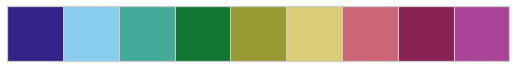

In [12]:
# Prepare plots
# Color from: https://personal.sron.nl/~pault/
colors = ["#332288", "#88CCEE", "#44AA99", "#117733", "#999933", "#DDCC77", "#CC6677", "#882255", "#AA4499"]
sns.set(style="whitegrid", color_codes=True, rc={'figure.figsize':(11.7,8.27)}, font_scale=1.4)
sns.set_palette(sns.color_palette(colors))
#sns.despine(left=True)
color = sns.color_palette(sns.color_palette(colors), 9)
sns.palplot(sns.color_palette(sns.color_palette(colors), 9))
color_primary = color[0]
color_kb = color[2]
color_r2 = color_primary
color_kv = color[6]
color_gv = color[5]

name_benchmark = "Benchmark"
name_kv = "JOIST"
name_kb = "Block size"
name_gv = "Gervais $\it{et}$ $\it{al.}$"

In [13]:
# Now we use linear regression to better predict the coefficients 
SHOW_COEF = False
MIN_TIME = False
#MIN_TIME = 870000000 # False or min verification time in ns (870000000ns = 10% of 8.7s, mean propagation time according to gervais et al.)
#MIN_TIME = blocks['BLOCK_NS_SSD'].quantile(0.75)

estimates_reg = blocks.copy(deep=True)
test_size = SAMPLE / estimates_reg['BLOCK'].count()
X_train, X_test = train_test_split(estimates_reg, train_size=test_size, random_state=42)

if MIN_TIME:
    X_test = X_test[X_test["BLOCK_NS_SSD"] > MIN_TIME]

print('Test Blocks: ' + str(X_test['BLOCK'].count()))
print('Train Blocks: ' + str(X_train['BLOCK'].count()))

# Block size OLS
regr_kb_hdd = LinearRegression().fit(X_train[["SIZE"]], X_train['BLOCK_NS_HDD'])
X_test['KB_HDD'] = regr_kb_hdd.predict(X_test[["SIZE"]])
print(name_kb + ' HDD...')
calculate_error(X_test['BLOCK_NS_HDD'], X_test['KB_HDD'])
print(name_kb + ' HDD adjst. R2: ', adj_r2_score(regr_kb_hdd, X_test['BLOCK_NS_HDD'], X_test['KB_HDD']))
if SHOW_COEF:
    print('Coefficients: \n', regr_kb_hdd.coef_)
    print('Intercept: \n', regr_kb_hdd.intercept_)

regr_kb_ssd = LinearRegression().fit(X_train[["SIZE"]], X_train['BLOCK_NS_SSD'])
X_test['KB_SSD'] = regr_kb_ssd.predict(X_test[["SIZE"]])
print(name_kb + ' SSD...')
calculate_error(X_test['BLOCK_NS_SSD'], X_test['KB_SSD'])
print(name_kb + ' adjst. R2: ', adj_r2_score(regr_kb_ssd, X_test['BLOCK_NS_SSD'], X_test['KB_SSD']))
if SHOW_COEF:
    print('Coefficients: \n', regr_kb_ssd.coef_)
    print('Intercept: \n', regr_kb_ssd.intercept_)

# Novel OLS
regr_kv_hdd = LinearRegression().fit(X_train[["numberVin", "numberJoinSplit", "numbervShieldedSpend", "numbervShieldedOutput"]], X_train['BLOCK_NS_HDD'])
X_test['KV_HDD'] = regr_kv_hdd.predict(X_test[["numberVin", "numberJoinSplit", "numbervShieldedSpend", "numbervShieldedOutput"]])
print(name_kv + ' HDD...')
calculate_error(X_test['BLOCK_NS_HDD'], X_test['KV_HDD'])
print(name_kv + ' HDD adjst. R2: ', adj_r2_score(regr_kv_hdd, X_test['BLOCK_NS_HDD'], X_test['KV_HDD']))
if SHOW_COEF:
    print('Coefficients: \n', regr_kv_hdd.coef_)
    print('Intercept: \n', regr_kv_hdd.intercept_)  

regr_kv_ssd = LinearRegression().fit(X_train[["numberVin", "numberJoinSplit", "numbervShieldedSpend", "numbervShieldedOutput"]], X_train['BLOCK_NS_SSD'])
X_test['KV_SSD'] = regr_kv_ssd.predict(X_test[["numberVin", "numberJoinSplit", "numbervShieldedSpend", "numbervShieldedOutput"]])
print(name_kv + ' SSD...')
calculate_error(X_test['BLOCK_NS_SSD'], X_test['KV_SSD'])
print(name_kv + ' adjst. R2: ', adj_r2_score(regr_kv_ssd, X_test['BLOCK_NS_SSD'], X_test['KV_SSD']))
if SHOW_COEF:
    print('Coefficients: \n', regr_kv_ssd.coef_)
    print('Intercept: \n', regr_kv_ssd.intercept_)

estimates_reg = X_test

r2_score_kv = r2_score(X_test['BLOCK_NS_SSD'], X_test['KV_SSD'])
r2_score_kb = r2_score(X_test['BLOCK_NS_SSD'], X_test['KB_SSD'])


Test Blocks: 10000
Train Blocks: 5000
Block size HDD...
MEAN aboslute error [ms]:  31.195802769236888
MAX error [ms]:  5396.243209117956
MEAN relative (%) error:  91.0796991027546
R2:  0.09099044724326855
Block size HDD adjst. R2:  0.09089952810416502
Block size SSD...
MEAN aboslute error [ms]:  10.594982491268016
MAX error [ms]:  1473.1114855546614
MEAN relative (%) error:  78.33573672636803
R2:  0.25197443361807337
Block size adjst. R2:  0.2518996160979311
JOIST HDD...
MEAN aboslute error [ms]:  22.051200672855643
MAX error [ms]:  5548.177754443923
MEAN relative (%) error:  64.38099179543188
R2:  0.16583717636109063
JOIST HDD adjst. R2:  0.1655033443156123
JOIST SSD...
MEAN aboslute error [ms]:  3.1090794591875786
MAX error [ms]:  840.3938446187217
MEAN relative (%) error:  22.987487726100838
R2:  0.9074870197437852
JOIST adjst. R2:  0.9074499960398308
ipykernel_launcher:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

In [14]:
# gervaivs' constant
def model(meNS_Byte, estimates, postfix):
    estimates['GER_' + postfix] = meNS_Byte * estimates["SIZE"]
    calculate_error(estimates["BLOCK_NS_" + postfix], estimates['GER_' + postfix])

def r2_adj_man(par, real, predicted):
    return 1 - float(len(real)-1)/(len(real)-par-1)*(1 - r2_score(real, predicted))

gervais = X_test.copy(deep=True)
meNS_Byte = 379.6

print('gervaivs KB SSD...')
model(meNS_Byte, gervais, 'SSD')
print('SSD adjst. R2: ', r2_adj_man(1, gervais["BLOCK_NS_SSD"], gervais['GER_SSD']))

print('gervaivs KB HDD...')
model(meNS_Byte, gervais, 'HDD')
print('HDD adjst. R2: ', r2_adj_man(1, gervais["BLOCK_NS_HDD"], gervais['GER_HDD']))

r2_score_ger = r2_score(gervais['BLOCK_NS_SSD'], gervais['GER_SSD'])

gervaivs KB SSD...
MEAN aboslute error [ms]:  11.658089214919997
MAX error [ms]:  1707.0374358
MEAN relative (%) error:  86.19599024586829
R2:  0.01367755877215504
SSD adjst. R2:  0.013578906797637291
gervaivs KB HDD...
MEAN aboslute error [ms]:  32.48408447622
MAX error [ms]:  5645.8861812
MEAN relative (%) error:  94.84098426985129
R2:  -0.028878280054932537
HDD adjst. R2:  -0.028981188464620056


In [23]:
# Linear regression with statsmodels
X = sm.add_constant(X_test[["numberVin", "numberJoinSplit", "numbervShieldedSpend", "numbervShieldedOutput"]])

est = sm.OLS(X_test['BLOCK_NS_SSD'], X)
est = est.fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           BLOCK_NS_SSD   R-squared:                       0.902
Model:                            OLS   Adj. R-squared:                  0.902
Method:                 Least Squares   F-statistic:                     5790.
Date:                Wed, 05 May 2021   Prob (F-statistic):               0.00
Time:                        17:34:19   Log-Likelihood:                -46445.
No. Observations:                2515   AIC:                         9.290e+04
Df Residuals:                    2510   BIC:                         9.293e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  8.213e+06   6.43e+05     12.782      0.000    6.95e+06    9.47e+06
numberVin              7.462e+04   5891.418     12.666      0.000    6.31e+04    8.62e+04
numberJoinSplit        1.753e+07   1.29e+05    135.559      0.000    1.73e+07    1.78e+07
numbervShieldedSpend   5.616e+06   9.13e+04     61.498      0.000    5.44e+06     5.8e+06
numbervShieldedOutput   5.04e+06   1.45e+05     34.740      0.000    4.76e+06    5.32e+06
==============================================================================
Omnibus:                     6013.538   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         52823258.569
Skew:                          23.866   Prob(JB):                         0.00
Kurtosis:                     711.379   Cond. No.                         120.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [7]:
# Compare KB with NS and size
estimates_KB = estimates_reg.copy(deep=True)
estimates_KB = estimates_KB.rename(columns={'BLOCK_NS_HDD': 'HDD', 'BLOCK_NS_SSD': 'SSD'})
estimates_KB['KB_GER'] = gervais["GER_SSD"]

# melt data
gridplotdata = pd.melt(estimates_KB, id_vars=['KB_HDD', 'KB_SSD', 'KB_GER', 'BLOCK', 'SIZE'], value_vars=['HDD', 'SSD'])

# Prepare plot
gridplotdata["SIZE"] = gridplotdata["SIZE"] / 1024 # Convert to Kibibyte
gridplotdata["value"] = gridplotdata["value"] / 1000000 # Convert to ms
gridplotdata["KB_HDD"] = gridplotdata["KB_HDD"] / 1000000 # Convert to ms
gridplotdata["KB_GER"] = gridplotdata["KB_GER"] / 1000000 # Convert to ms
gridplotdata["KB_SSD"] = gridplotdata["KB_SSD"] / 1000000 # Convert to ms

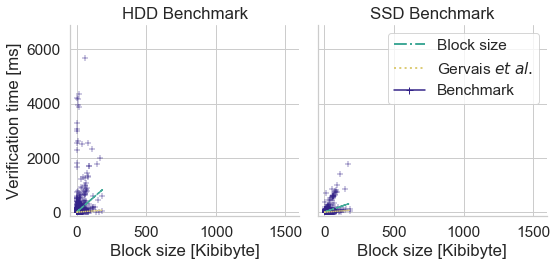

In [10]:
grid = sns.FacetGrid(gridplotdata, col="variable", height=4, aspect=1, legend_out=False)
grid = grid.map(sns.scatterplot, "SIZE", "value", color=color_primary, marker='+')
grid.set(ylim=(-150, 6900), xlim=(-50, 1600))

ax1, ax2 = grid.axes[0]
ax1.plot(gridplotdata["SIZE"], gridplotdata["KB_HDD"], ls='-.', color=color_kb)
ax2.plot(gridplotdata["SIZE"], gridplotdata["KB_SSD"], ls='-.', color=color_kb)

ax1.plot(gridplotdata["SIZE"], gridplotdata["KB_GER"], ls=':', color=color_gv)
ax2.plot(gridplotdata["SIZE"], gridplotdata["KB_GER"], ls=':', color=color_gv)

from matplotlib.lines import Line2D
b_patch = Line2D([0], [0], color=color_kb, ls='-.', lw=2, label=name_kb)
b2_patch = Line2D([0], [0], color=color_gv, ls=':', lw=2, label=name_gv)
g_patch = Line2D([0], [0], marker='+', color=color_primary, label=name_benchmark, markersize=7)
plt.legend(handles=[b_patch, b2_patch, g_patch])

grid.set_xlabels('Block size [Kibibyte]')
grid.set_ylabels('Verification time [ms]')
grid.set_titles('{col_name} Benchmark')

if SAVE_FIGURES:
    grid.fig.savefig("KB_SIZE" + FILE, bbox_inches='tight', dpi=DPI, rasterized=True)

In [24]:
model_error = estimates_reg.copy(deep=True)
model_error["GER"] = gervais["GER_SSD"]

def relative_error(real, predict):
    return (abs(real - predict) / real)

def abs_error(real, predict):
    return (abs(real - predict))

model_error['KV_HDD_mae'] = model_error.apply(lambda row : (abs_error(row['BLOCK_NS_HDD'], row['KV_HDD'])), axis = 1) 
model_error['KV_SSD_mae'] = model_error.apply(lambda row : (abs_error(row['BLOCK_NS_SSD'], row['KV_SSD'])), axis = 1) 

model_error['KB_HDD_mae'] = model_error.apply(lambda row : (abs_error(row['BLOCK_NS_HDD'], row['KB_HDD'])), axis = 1) 
model_error['KB_SSD_mae'] = model_error.apply(lambda row : (abs_error(row['BLOCK_NS_SSD'], row['KB_SSD'])), axis = 1) 

model_error['KV_HDD_re'] = model_error.apply(lambda row : (relative_error(row['BLOCK_NS_HDD'], row['KV_HDD'])), axis = 1) 
model_error['KV_SSD_re'] = model_error.apply(lambda row : (relative_error(row['BLOCK_NS_SSD'], row['KV_SSD'])), axis = 1) 

model_error['KB_HDD_re'] = model_error.apply(lambda row : (relative_error(row['BLOCK_NS_HDD'], row['KB_HDD'])), axis = 1) 
model_error['KB_SSD_re'] = model_error.apply(lambda row : (relative_error(row['BLOCK_NS_SSD'], row['KB_SSD'])), axis = 1) 

model_error['GER_SSD_re'] = model_error.apply(lambda row : (relative_error(row['BLOCK_NS_SSD'], row['GER'])), axis = 1) 

model_error_ssd = pd.melt(model_error.rename(columns={'KV_SSD_mae': name_kv, 'KB_SSD_mae': name_kb}), id_vars=['BLOCK', 'SIZE', 'BLOCK_NS_SSD'], value_vars=[name_kv, name_kb], var_name='Model', value_name='MAE')

model_error_hdd = pd.melt(model_error.rename(columns={'KV_HDD_mae': name_kv, 'KB_HDD_mae': name_kb}), id_vars=['BLOCK', 'SIZE', 'BLOCK_NS_HDD'], value_vars=[name_kv, name_kb], var_name='Model', value_name='MAE')

model_error_ssd["BLOCK_NS_SSD"] = model_error_ssd["BLOCK_NS_SSD"] / 1000000 # Convert to mss
model_error_ssd["MAE"] = model_error_ssd["MAE"] / 1000000 # Convert to mss
model_error_ssd["SIZE"] = model_error_ssd["SIZE"] / 1024 # Convert to Kibibyte

model_error_hdd["BLOCK_NS_HDD"] = model_error_hdd["BLOCK_NS_HDD"] / 1000000 # Convert to mss
model_error_hdd["MAE"] = model_error_hdd["MAE"] / 1000000 # Convert to mss
model_error_hdd["SIZE"] = model_error_hdd["SIZE"] / 1024 # Convert to Kibibyte

In [17]:
# Plot error 
Q = 25
d1_bins = model_error_ssd.copy(deep=True)
d1_bins['NS_BINS'] = pd.qcut(d1_bins['BLOCK_NS_SSD'], Q)

g = sns.catplot(x="NS_BINS", 
                y="MAE",
                kind="point",
                estimator=mean,
                hue="Model",
                height=6,
                data=d1_bins,
                palette=[color_kv, color_kb]);
g.set(ylabel="MAE [ms]", xlabel="Verification time [ms]", yscale='log')

if SAVE_FIGURES:   
    g.fig.savefig("MAE_SSD" + FILE, bbox_inches='tight', dpi=DPI, rasterized=True)

ValueError: Could not interpret input 'MAE'

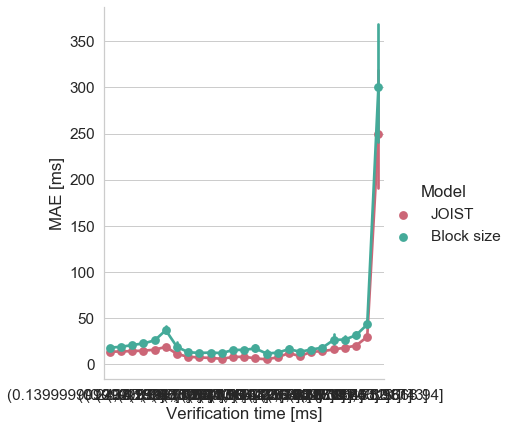

In [12]:
d1_bins = model_error_hdd.copy(deep=True)
d1_bins['NS_BINS'], edges = pd.qcut(d1_bins['BLOCK_NS_HDD'], Q, retbins=True)

g = sns.catplot(x="NS_BINS", 
                y="MAE",
                kind="point",
                estimator=mean,
                hue="Model",
                height=6,
                data=d1_bins,
                palette=[color_kv, color_kb]);
g.set(ylabel="MAE [ms]", xlabel="Verification time [ms]")

if SAVE_FIGURES:   
    g.fig.savefig("MAE_HDD" + FILE, bbox_inches='tight', dpi=DPI, rasterized=True)

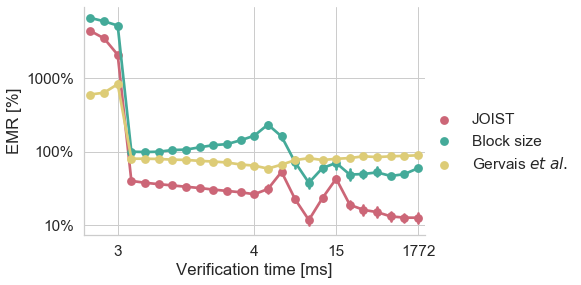

In [33]:
d1_bins = pd.melt(model_error.rename(columns={'KV_SSD_re': name_kv, 'KB_SSD_re': name_kb, 'GER_SSD_re': name_gv}), id_vars=['BLOCK', 'SIZE', 'BLOCK_NS_SSD'], value_vars=[name_kv, name_kb, name_gv], var_name='Model', value_name='EMR')
d1_bins["BLOCK_NS_SSD"] = d1_bins["BLOCK_NS_SSD"] / 1000000 # Convert to mss
d1_bins['NS_BINS'], edges = pd.qcut(d1_bins['BLOCK_NS_SSD'], Q, retbins=True)

g = sns.catplot(x="NS_BINS", 
                y="EMR",
                kind="point",
                estimator=mean,
                legend=False,
                hue="Model",
                height=4,
                aspect=1.5,
                data=d1_bins,
                palette=[color_kv, color_kb, color_gv], orient='v');

g.set(ylabel="EMR [%]", xlabel="Verification time [ms]", yscale='log')
g.add_legend()

edges = edges.astype(int)
from matplotlib.ticker import PercentFormatter 
for ax in g.axes.flat:
    ax.set_xticklabels(edges)

ticks = ax.get_xticks()
labels = ax.get_xticklabels()
for ax in g.axes.flat:
    ax.set_xticks([ticks[2], ticks[12], ticks[18], ticks[24]])
    ax.xaxis.grid(True)
    ax.set_xticklabels([edges[3], edges[13], edges[19], edges[25]])
    ax.yaxis.set_major_formatter(PercentFormatter(1))

if SAVE_FIGURES:   
    g.fig.savefig("EMR" + FILE, bbox_inches='tight', dpi=DPI, rasterized=True)

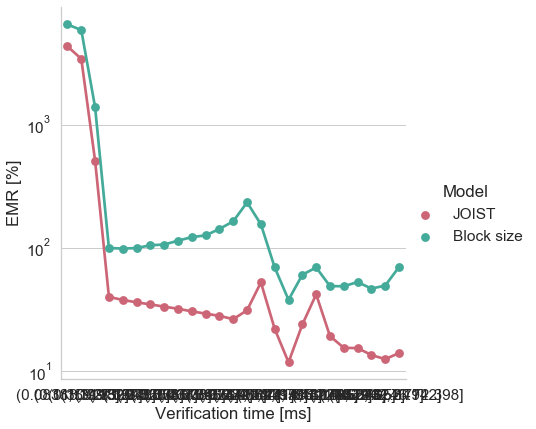

In [13]:
# Plot relative error
from numpy import mean

d1_bins = model_error_ssd.copy(deep=True)
d1_bins['NS_BINS'], edges = pd.qcut(d1_bins['BLOCK_NS_SSD'], Q)
Models = [name_kv, name_kb]

for cat in d1_bins.NS_BINS.cat.categories:
    for model in Models:
        m = mean(d1_bins[(d1_bins.NS_BINS == cat) & (d1_bins.Model == model)]['BLOCK_NS_SSD'])
        mean_error = mean(d1_bins[(d1_bins.NS_BINS == cat) & (d1_bins.Model == model)]['MAE'])
        d1_bins.loc[(d1_bins.NS_BINS == cat) & (d1_bins.Model == model), 'MAE_h'] = mean_error / m * 100

def emp_error(x, **kws):
    m = mean(x)
    x[-1]

g = sns.catplot(x="NS_BINS", 
                y="MAE_h",
                kind="point",
                estimator=mean,
                hue="Model",
                height=6,
                data=d1_bins,
                palette=[color_kv, color_kb, color_gv], orient='v');
g.set(ylabel="EMR [%]", xlabel="Verification time [ms]", yscale='log')

if SAVE_FIGURES:   
    g.fig.savefig("EMR" + FILE, bbox_inches='tight', dpi=DPI, rasterized=True)

In [15]:
g.set(ylim=(None, 1000))
g.fig
if SAVE_FIGURES:   
    g.fig.savefig("RE_Zoom" + FILE, bbox_inches='tight', dpi=DPI, rasterized=True)

In [15]:
# Compare all models based on block size
estimates_reg['GER_HDD'] = gervais["GER_SSD"]
estimates_reg['GER_SSD'] = gervais["GER_SSD"]

d1 = pd.melt(estimates_reg.rename(columns={'BLOCK_NS_HDD': 'HDD', 'BLOCK_NS_SSD': 'SSD'}), id_vars=['BLOCK', 'SIZE', 'KV_SSD', 'KV_HDD', 'KB_SSD', 'KB_HDD', 'GER_HDD', 'GER_SSD'], value_vars=['HDD', 'SSD'], var_name='Type', value_name=name_benchmark)

d1['KV'] = d1['KV_HDD']
d1['KB'] = d1['KB_HDD']
d1['GER'] = d1['GER_HDD']

d1.loc[d1['Type'] == 'SSD', 'KV'] = d1['KV_SSD']
d1.loc[d1['Type'] == 'SSD', 'KB'] = d1['KB_SSD']

d1 = pd.melt(d1.rename(columns={'KV': name_kv, 'KB': name_kb, 'GER': name_gv}), id_vars=['BLOCK', 'SIZE', 'Type'], value_vars=[name_benchmark, name_kv, name_kb, name_gv], var_name='Model', value_name='NS')

d1["NS"] = d1["NS"] / 1000000 # Convert to mss
d1["SIZE"] = d1["SIZE"] / 1024 # Convert to Kibibyte

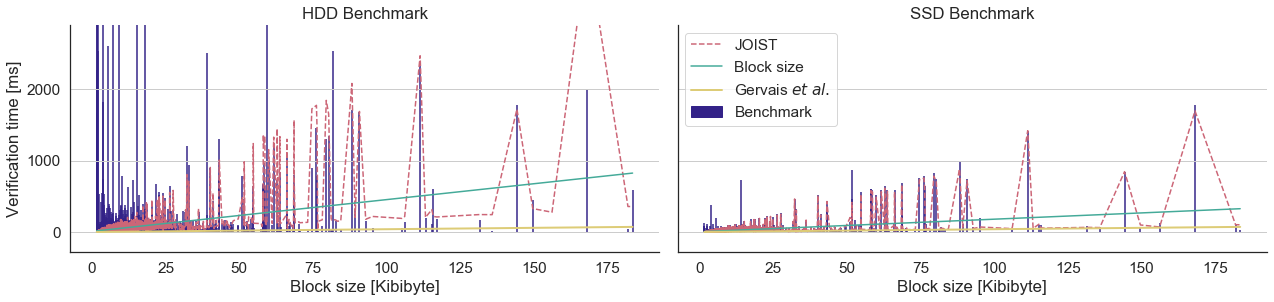

In [17]:
sns.set(style="white", font_scale=1.4)

grid = sns.FacetGrid(d1[(d1['Model']!='Benchmark')], col="Type", height=4.5, aspect=2, hue="Model", hue_kws={'color':[color_kv, color_kb, color_gv], 'ls': ["--", "-", "-"], 'lw': [1.5, 1.5, 2]}, legend_out=False)
ax1, ax2 = grid.axes[0]
ax1.set_rasterization_zorder(0.1);
ax2.set_rasterization_zorder(0.1);

grid = grid.map(sns.lineplot, "SIZE", "NS")
for _, row in d1[(d1['Model']=='Benchmark') & (d1['Type']=='HDD')].iterrows():
    ax1.vlines(x=row["SIZE"], ymax=row["NS"], ymin=0, color=color_primary, zorder=0)

for _, row in d1[(d1['Model']=='Benchmark') & (d1['Type']=='SSD')].iterrows():
    ax2.vlines(x=row["SIZE"], ymax=row["NS"], ymin=0, color=color_primary, zorder=0)

grid.set(ylim=(None, 2900))
ax1.grid(axis='y')
ax2.grid(axis='y')
ax2.legend(title='')

import matplotlib.patches as mpatches
# where some data has already been plotted to ax
handles, labels = ax2.get_legend_handles_labels()
# manually define a new patch 
patch = mpatches.Patch(color=color_primary, label='Benchmark')
# handles is a list, so append manual patch
handles.append(patch) 
# plot the legend
ax2.legend(handles=handles, loc='upper left')

grid.set_xlabels('Block size [Kibibyte]')
grid.set_ylabels('Verification time [ms]')
grid.set_titles('{col_name} Benchmark')

if SAVE_FIGURES:
    sns.set(font_scale=1.5)
    grid.fig.savefig("KV_KB_Size" + FILE, bbox_inches='tight', dpi=DPI, rasterized=True)


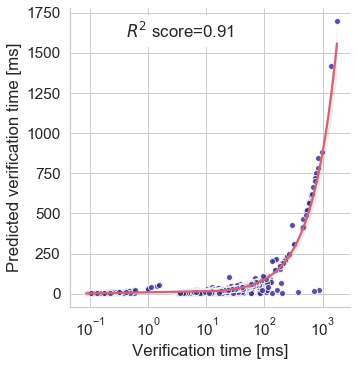

In [18]:
# Compare models with real values
sns.set(style="whitegrid", font_scale=1.4)

HEIGHT=5
RATIO=1
ZOOM = False #750
gridplotdata = estimates_reg.copy(deep=True)

gridplotdata["BLOCK_NS_SSD"] = gridplotdata["BLOCK_NS_SSD"] / 1000000 # 1000000 # Convert to ms
gridplotdata["KV_SSD"] = gridplotdata["KV_SSD"] / 1000000 # 1000000 # Convert to ms
gridplotdata["KB_SSD"] = gridplotdata["KB_SSD"] / 1000000 # 1000000 # Convert to ms
gridplotdata["GER_SSD"] = gridplotdata["GER_SSD"] / 1000000 # 1000000 # Convert to ms

grid = sns.lmplot(data=gridplotdata, x='BLOCK_NS_SSD', y='KV_SSD', height=HEIGHT, aspect=RATIO, scatter_kws={'edgecolor': 'white', 'color': color_r2, 'marker':['+'], 'rasterized':True}, line_kws={'color': color_kv})

if ZOOM:
    grid.set(ylim=(0, ZOOM))
    grid.set(xlim=(0, ZOOM))

grid.axes.ravel()[0].annotate("$R^2$ score=" + str(round(r2_score_kv, 2)), (0.2, 0.9), bbox=dict(boxstyle="square", fc="w"), xycoords='axes fraction')

#grid.ax_joint.set_yscale('log')
grid.set(xscale='log', xlabel='Verification time [ms]', ylabel='Predicted verification time [ms]')

if SAVE_FIGURES:
    grid.fig.savefig("KV_R2" + FILE, bbox_inches='tight', dpi=DPI, rasterized=True)

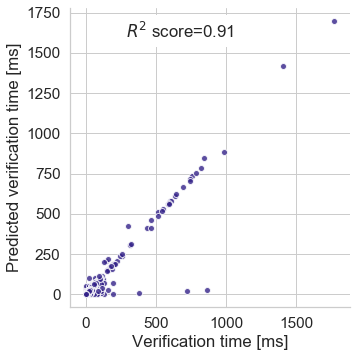

In [19]:
gridplotdata_scaled = gridplotdata.copy(deep=True)
#gridplotdata_scaled["BLOCK_NS_SSD"] = np.log1p(gridplotdata_scaled["BLOCK_NS_SSD"])
#gridplotdata_scaled["KV_SSD"] = np.log1p(gridplotdata_scaled["KV_SSD"])

grid = sns.lmplot(data=gridplotdata_scaled, x='BLOCK_NS_SSD', fit_reg=False, y='KV_SSD', scatter_kws={'edgecolor': 'white', 'color': color_r2, 'marker':['+'], 'rasterized':True}, line_kws={'color': color_kv})

if ZOOM:
    grid.set(ylim=(0, ZOOM))
    grid.set(xlim=(0, ZOOM))

grid.axes.ravel()[0].annotate("$R^2$ score=" + str(round(r2_score_kv, 2)), (0.2, 0.9), bbox=dict(boxstyle="square", fc="w"), xycoords='axes fraction')

grid.set(xlabel='Verification time [ms]', ylabel='Predicted verification time [ms]')

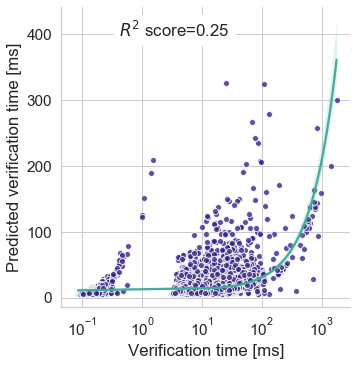

In [20]:
grid = sns.lmplot(data=gridplotdata, x='BLOCK_NS_SSD', y='KB_SSD', height=HEIGHT, aspect=RATIO, scatter_kws={'edgecolor': 'white', 'color': color_r2, 'marker':['+'], 'rasterized':True}, line_kws={'color': color_kb})

grid.axes.ravel()[0].annotate("$R^2$ score=" + str(round(r2_score_kb, 2)), (0.2, 0.9), bbox=dict(boxstyle="square", fc="w"), xycoords='axes fraction')

#grid.ax_joint.set_yscale('log')
grid.set(xscale='log', xlabel='Verification time [ms]', ylabel='Predicted verification time [ms]')


if SAVE_FIGURES:
    grid.fig.savefig("KB_R2" + FILE, bbox_inches='tight', dpi=DPI, rasterized=True)

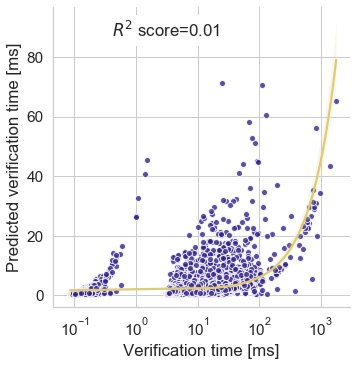

In [21]:
grid = sns.lmplot(data=gridplotdata, x='BLOCK_NS_SSD', y='GER_SSD', height=HEIGHT, aspect=RATIO, scatter_kws={'edgecolor': 'white', 'color': color_r2, 'marker':['+'], 'rasterized':True}, line_kws={'color': color_gv})

grid.axes.ravel()[0].annotate("$R^2$ score=" + str(round(r2_score_ger, 2)), (0.2, 0.9), bbox=dict(boxstyle="square", fc="w"), xycoords='axes fraction')

#grid.ax_joint.set_yscale('log')
grid.set(xscale='log', xlabel='Verification time [ms]', ylabel='Predicted verification time [ms]')

if SAVE_FIGURES:
    grid.fig.savefig("GER_R2" + FILE, bbox_inches='tight', dpi=DPI, rasterized=True)

In [22]:
# Plot per block
BLOCKS = 200

# Include block height
d1_block = estimates_reg.copy(deep=True)
tmp = blocks_info.copy(deep=True)
tmp = tmp.reset_index()
tmp = tmp.rename(columns = {'index':'height'})
d1_block = d1_block.merge(tmp, how='inner', left_on="BLOCK", right_on="BLOCK")
d1_block = d1_block.sort_values(by=['height']).tail(BLOCKS)

# Preapre plot data
d1_block = d1_block.rename(columns={'BLOCK_NS_SSD': 'Benchmark', 'KB_SSD': 'Naive Model', 'KV_SSD': 'Improved Model'})
kb_gridplotdata = pd.melt(d1_block, id_vars=['height'], value_vars=['Benchmark', 'Naive Model'], var_name="Model")
kv_gridplotdata = pd.melt(d1_block, id_vars=['height'], value_vars=['Benchmark', 'Improved Model'], var_name="Model")

kb_gridplotdata["value"] = kb_gridplotdata["value"] / 1000000 # 1000000 # Convert to ms
kv_gridplotdata["value"] = kv_gridplotdata["value"] / 1000000 # 1000000 # Convert to ms

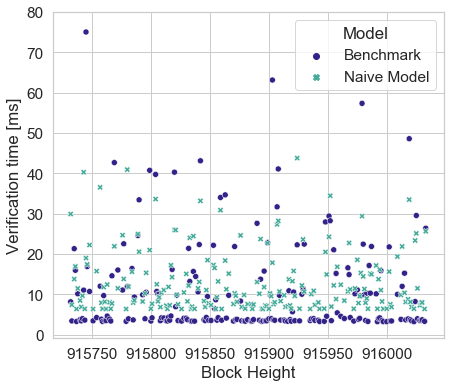

In [23]:
# KB plot
grid = sns.scatterplot(data=kb_gridplotdata, x='height', y='value', hue="Model", style="Model", palette=[color_primary, color_kb])
grid.set(xlabel='Block Height', ylabel='Verification time [ms]')
grid.get_figure().set_size_inches(7, 6)
grid.set(ylim=(None, 80))

if SAVE_FIGURES:
    grid.get_figure().savefig("Block_KB" + FILE, bbox_inches='tight', dpi=DPI, rasterized=True)

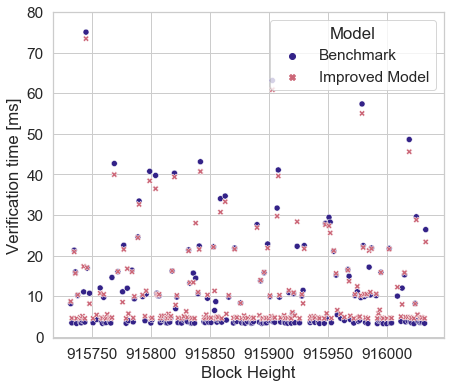

In [24]:
# KV plot
grid = sns.scatterplot(data=kv_gridplotdata, x='height', y='value', hue="Model", style="Model", palette=[color_primary, color_kv])
grid.set(xlabel='Block Height', ylabel='Verification time [ms]')
grid.get_figure().set_size_inches(7, 6)
grid.set(ylim=(None, 80))

if SAVE_FIGURES:
    grid.get_figure().savefig("Block_KV" + FILE, bbox_inches='tight', dpi=DPI, rasterized=True)

In [14]:
d1

BLOCK       SIZE Type  \
0       0000000000c70d5c3ae297b2659d2f7e1adb3efb6ec8a1...   4.410156  HDD   
1       000000000087bbc3b32be154a6a014db308941ee82fe4e...  18.121094  HDD   
2       0000000000779f484a3f42c82069666d571ab1f0afd9d8...  11.102539  HDD   
3       0000000000d5bdc7abb3d73a43a2a3f243b02769b12e5e...  23.183594  HDD   
4       0000000000a7c99bdc01bcf0080fb9d884105572823b52...   7.204102  HDD   
...                                                   ...        ...  ...   
400091  00000000027a6733e2e54b803bfc34b46a3b9d141f6093...  35.073242  SSD   
400092  0000000000aef0482cf6315bb4f10a7c3ed53ec288a304...   2.787109  SSD   
400093  0000000001836f5442bf2c400bf5abc85d179a04ecea09...   6.086914  SSD   
400094  000000000025d9b16aca7012274c8b88db366acf0a9047...   9.945312  SSD   
400095  0000000000e82c5f1f783fe3cad2d5d5608d95dc583865...   3.038086  SSD   

                               Model         NS  
0                          Benchmark  53.713418  
1                          Benchmark  67.126695  
2                          Benchmark  45.157505  
3                          Benchmark  13.780360  
4                          Benchmark  84.783596  
...                              ...        ...  
400091  Gervais $\it{et}$ $\it{al.}$  13.633334  
400092  Gervais $\it{et}$ $\it{al.}$   1.083378  
400093  Gervais $\it{et}$ $\it{al.}$   2.366047  
400094  Gervais $\it{et}$ $\it{al.}$   3.865846  
400095  Gervais $\it{et}$ $\it{al.}$   1.180936  

[400096 rows x 5 columns]

In [16]:
# Max Error analysis
max_joist = d1[d1["Model"] == name_kv]['NS'].max()
max_block = d1[d1["Model"] == name_kb]['NS'].max()
max_gervais = d1[d1["Model"] == name_gv]['NS'].max()

block_count = d1[d1["Model"] == "Benchmark"].count()

print("Blocks not covered by JOIST: ", d1[d1['NS'] > max_joist].count())
print(d1[d1['NS'] > max_joist].count() * 100 / block_count)

print("Blocks not covered by BLOCK: ", d1[d1['NS'] > max_block].count())
print(d1[d1['NS'] > max_block].count() * 100 / block_count)

print("Blocks not covered by GERVAIS: ", d1[d1['NS'] > max_gervais].count())
print(d1[d1['NS'] > max_gervais].count() * 100 / block_count)


Blocks not covered by JOIST:  BLOCK    4
SIZE     4
Type     4
Model    4
NS       4
dtype: int64
BLOCK    0.02
SIZE     0.02
Type     0.02
Model    0.02
NS       0.02
dtype: float64
Blocks not covered by BLOCK:  BLOCK    68
SIZE     68
Type     68
Model    68
NS       68
dtype: int64
BLOCK    0.34
SIZE     0.34
Type     0.34
Model    0.34
NS       0.34
dtype: float64
Blocks not covered by GERVAIS:  BLOCK    2849
SIZE     2849
Type     2849
Model    2849
NS       2849
dtype: int64
BLOCK    14.245
SIZE     14.245
Type     14.245
Model    14.245
NS       14.245
dtype: float64


In [48]:
d1[d1['NS'] > max_joist]


BLOCK       SIZE Type  \
744   000000000033bce032c0374ef71807e218e01c47ce5319...  59.309570  HDD   
2627  00000000027e01a38d533baca664272496ec0d877c9bfc...  15.396484  HDD   
7486  00000000006e0942c49d4ca44dd20988da4999bd425194...   7.200195  HDD   
9954  00000000020d88ed3f1bb22445c9e9ef6e819ae32ded21...   2.116211  HDD   

          Model           NS  
744   Benchmark  5668.940428  
2627  Benchmark  4363.695110  
7486  Benchmark  4160.407288  
9954  Benchmark  4204.119668

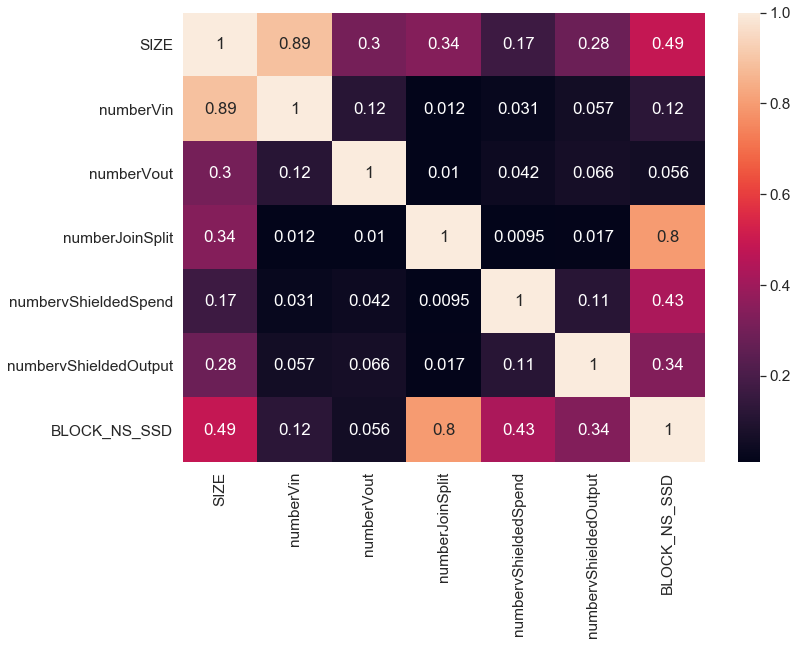

In [25]:
# Correlation
def pearsonr_pval(x,y):
    return pearsonr(x,y)[1]

data_scaled = blocks[["SIZE", "numberVin", "numberVout", "numberJoinSplit", "numbervShieldedSpend", "numbervShieldedOutput", "BLOCK_NS_SSD"]]
#data_scaled["BLOCK_NS_SSD"] = np.log1p(data_scaled["BLOCK_NS_SSD"])

corrMatrix = data_scaled[["SIZE", "numberVin", "numberVout", "numberJoinSplit", "numbervShieldedSpend", "numbervShieldedOutput", "BLOCK_NS_SSD"]].corr()
pvalues = data_scaled[["SIZE", "numberVin", "numberVout", "numberJoinSplit", "numbervShieldedSpend", "numbervShieldedOutput", "BLOCK_NS_SSD"]].corr(method=pearsonr_pval)
sns.heatmap(corrMatrix, annot=True)
plt.show()

In [26]:
abs(corrMatrix['BLOCK_NS_SSD'].sort_values())

numberVout               0.056160
numberVin                0.124236
numbervShieldedOutput    0.335796
numbervShieldedSpend     0.430726
SIZE                     0.487774
numberJoinSplit          0.795232
BLOCK_NS_SSD             1.000000
Name: BLOCK_NS_SSD, dtype: float64

In [27]:
pvalues['BLOCK_NS_SSD'] < 0.01

SIZE                      True
numberVin                 True
numberVout                True
numberJoinSplit           True
numbervShieldedSpend      True
numbervShieldedOutput     True
BLOCK_NS_SSD             False
Name: BLOCK_NS_SSD, dtype: bool

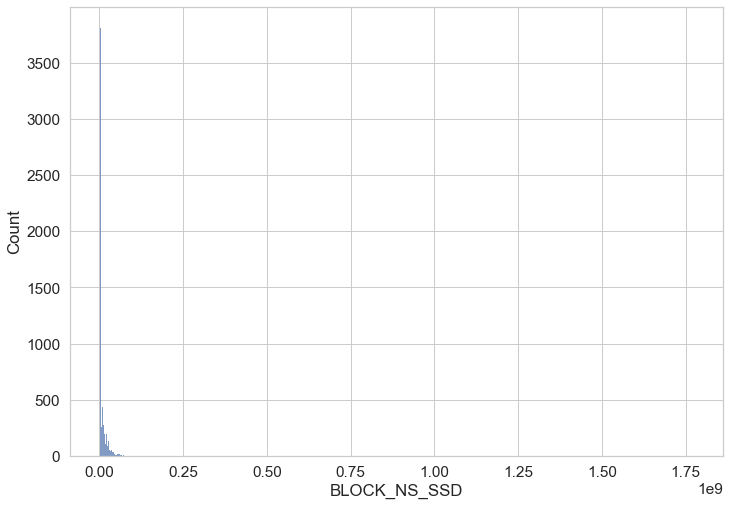

In [28]:
sns.histplot(data_scaled, x="BLOCK_NS_SSD")

In [29]:
data_scaled.count()

SIZE                     15000
numberVin                15000
numberVout               15000
numberJoinSplit          15000
numbervShieldedSpend     15000
numbervShieldedOutput    15000
BLOCK_NS_SSD             15000
dtype: int64